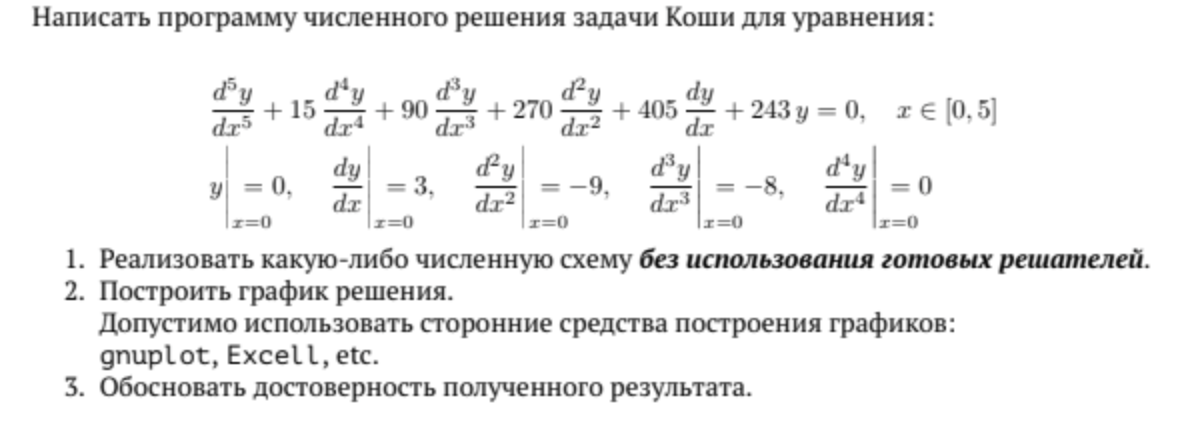

#Пункт 1

 Начальное  обыкновенное дифференциальное уравнение пятого порядка

$
\dfrac{d^5 y}{dx^5} + 15 \dfrac{d^4 y}{dx^4}+90\dfrac{d^3 y}{dx^3} + 270\dfrac{d^2 y}{dx^2} + 405 \dfrac{dy}{dx} + 243y = 0,
$

может быть сведено к системе дифференциальных уравнений первого порядка следующей заменой 

$\begin{cases}
   z_1 = y \\
   z_2 = z_1'\\
   z_3 = z_2'\\
   z_4 = z_3'\\
   z_5 = z_4'\\
 \end{cases},$
 
тогда получим систему дифференциальных уравнений первого порядка, эквивалентную начальному дифференциальному уравнению


$\begin{cases}
   z_1'= z_2\\
   z_2'= z_3\\
   z_3'= z_4\\
   z_4' = z_5\\
   z_5' = -15z_5-90z_4-270z_3-405z_2-243z_1
 \end{cases}.$

 Воспользуемся разностной схемой Эйлера, для численного приближения операции дифференцирования функции $f(x)$ с точностью до линейных слагаемых

$f'(x)\sim \dfrac{f(x+h)-f(x)}{h},$
где $h~-$ шаг(параметр дискретизации).

В дальнейшем при использования разностной схемы Эйлера знак эквивалентности в системе будет заменен на равенства, предполагая, что всегда можно выбрать достаточно малый параметр дискретизации. При применении разностной схемы Эйлера для системы дифференциальных уравнений первого порядка, и некоторых алгебраических действий можно получить следующую систему

$\begin{cases}
   z_1(x + h) = z_2(x)h +z_1(x)\\
   z_2(x + h) = z_3(x)h +z_2(x)\\
   z_3(x + h) = z_4(x)h +z_3(x)\\
   z_4(x + h) = z_5(x)h +z_4(x)\\
   z_5(x + h) = f_{sc}(x)h +z_5(x)
 \end{cases},$
 
где $f_{sc}(x)=-15z_5(x)-90z_4(x)-270z_3(x)-405z_2(x)-243z_1(x).$





Установим библиотеки на локальную машину

In [238]:
! pip install dataclassy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Преед тем, как перейти к решению системы дифференциальных уравнений первого порядка, стоит заметить, что система легко векторизуется, поэтому в качестве основного типа данных было принято решение реализовать векторизованный класс Functions. Так как в этом типе данных используется идея, что каждая функция $–$ набор образов и их сопоставлений, то начальные условния для дифференциального уравнения используются для инициализации класса. 

In [239]:
import matplotlib.pyplot as plt
from typing import NewType
 

Number = NewType('Number', (int, float))

from dataclassy import dataclass
@dataclass(slots=True)
class Functions:
  _patterns:list
 
  def extend(self, ind:int ,couple:tuple):
    domain, codomain = couple
    self._patterns[ind][domain] = codomain

  def __call__(self, ind:int, value:Number) -> Number:
    codom = self._patterns[ind].get(value)
    if codom is None:
      codom = self._patterns[ind].get(list(sorted(map(lambda x:(abs(x-value),x),
                                                     self._patterns[ind].keys()),
                                                      key=lambda x:x[0]))[0][1])
      self.extend(ind,(value,codom))
    return codom

  def get_domain(self, ind:int, interval:tuple=None) -> tuple:
    return self.__get_val_from_lst(self._patterns[ind].keys(), interval)

  def get_codomain(self, ind:int, interval:tuple=None) -> tuple:
    return self.__get_val_from_lst(self._patterns[ind].values(), interval) 

  @staticmethod
  def __get_val_from_lst(lst:list, interval:tuple=None)-> tuple:
    if interval is None:
      return tuple(lst)
    return tuple(filter( lambda x:interval[0] <= x <= interval[1],lst))

  def __len__(self) -> int:
    return len(self._patterns)    

Далее представлены функции для отрисовки графика и построения начальной сетки

In [240]:
def print_graph(f:Functions,interval=None, ind=0):
  plt.plot(f.get_domain(ind, interval), f.get_codomain(ind,interval))
  plt.show()

def grid(inter:tuple,h:float=None,count_knots:int=None)->list:
  a, b = inter
  d = (b-a)
  if count_knots:
    h = d/count_knots
  if h is None:
    h = 1e-4
  return [ a+i*h for i in range(0,int(d/h)+1)]    

Програмная реализации численного решения представляет из себя пару функций. Одна из которых опписывает способ вычисления значения каждой функции $z_i$ в точке $x+h$ и сохранении значения. Другая функциия содержит в себе програмную реализацию фунции $f_{sc}(x)$ на векторном типе данных Functions.

In [241]:

def spicialF(x,f:Functions):
  return -15*f(4,x) - 90*f(3,x) - 270 * f(2,x) - 405*f(1,x) - 243*f(0,x)


def calculate(f:Functions,ind:int,h:float, x, spicialF):
  try:
    codom = f(ind+1,x)*h +f(ind,x)
  except IndexError:
    codom = spicialF(x,f)*h +f(ind,x)
  f.extend(ind,(x+h,codom))  

# Пункт 2

Сборка решения из написанных ранее функций принимает следующий вид

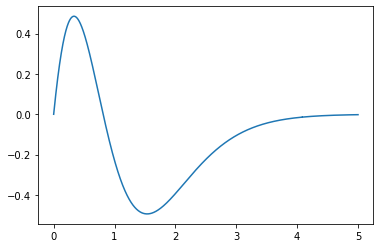

In [258]:
new_functions = Functions([
    {0:0},
    {0:3},
    {0:-9},
    {0:-8},
    {0:0},
])

h=1e-3

for x in grid((0,5),h):
  for ind in range(len(new_functions)):
    calculate(new_functions,ind,h,x, spicialF)
  
print_graph(new_functions)

# Пункт 3

Реализованная схема для вычисления решения имеет серьезный недостаток $–$ точность приближения, при выборе достаточно малого шага, возникает большое количество вычислений, которые серьезно влияют скорость работы программы( на каждом узле происходит порядка 12-14 вызовов вычисления одной из функциий класса Functions). 

Из плюсов стоит отметить простоту реализации метода и тип схемы.

Сравним работу метода для решения дифференциального уравнении второго порядка
$y''-2y'+2y=0,$ 

с начальными условиями: $y(0)=0, y'(0)=1$
 оно имеет аналитичекое решение: $y = e^x\sin(x)$

Подтверждаение с [сайта](https://www.wolframalpha.com/input?i=solve+%7By%27%27-2y%27%2B2y%7D%2C+y%280%29%3D0%2C+y%27%280%29%3D1) 
 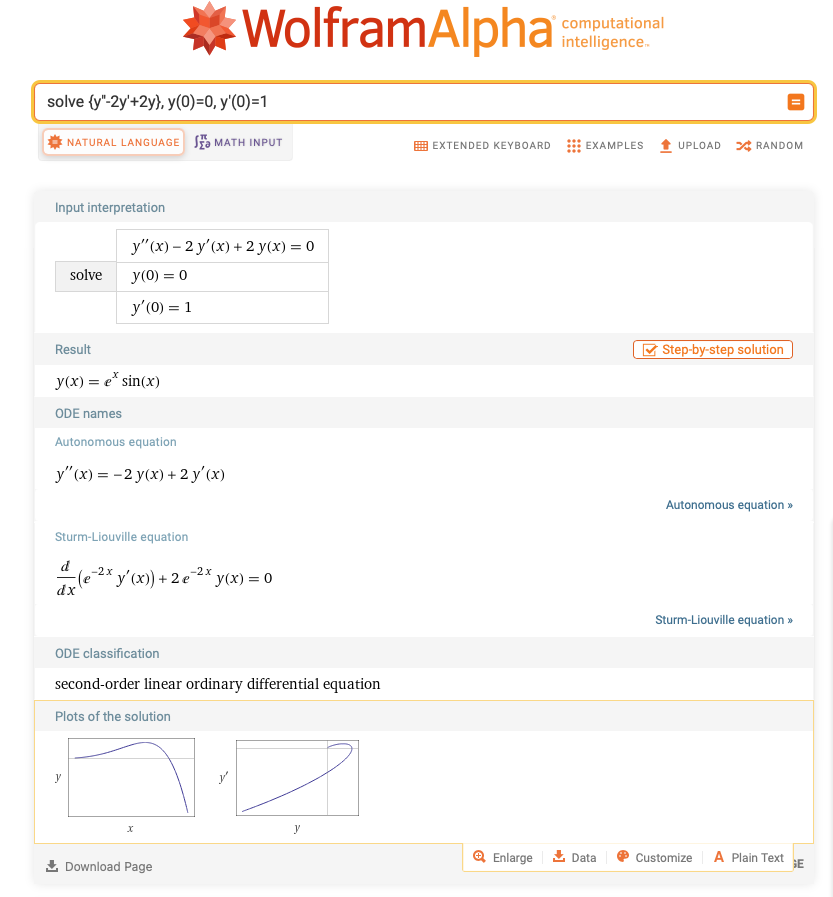

 на [сайте](https://www.desmos.com/calculator/hsq3ikjqx8)  можно увидеть график решения и узнать его значение в точке $x=2$
 

 



 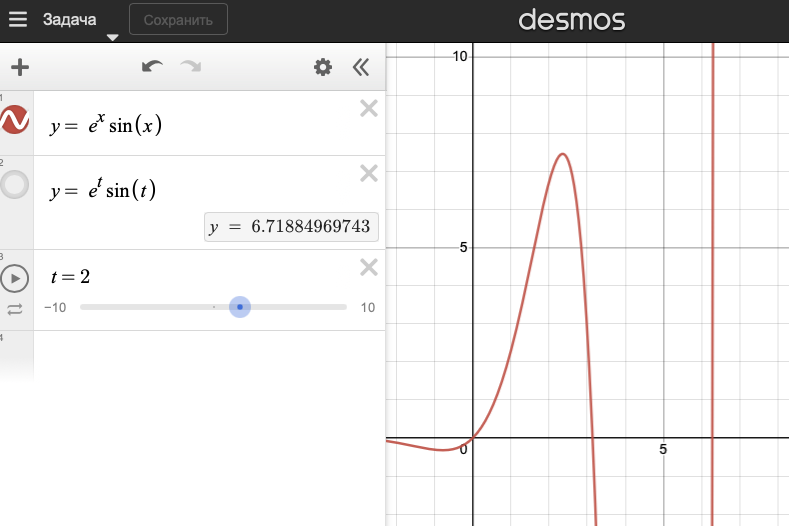

Сравним с решением, полученным в результате работы программы

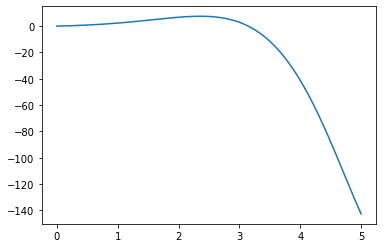

In [259]:
new_functions2 = Functions([
    {0:0},
    {0:1},

])
def sp_f(x,f:Functions):
  return 2*f(1,x) - 2*f(0,x) 

h=1e-3

for x in grid((0,5),h):
  for ind in range(len(new_functions2)):
    calculate(new_functions2,ind,h,x, sp_f)
  
print_graph(new_functions2)

Рассмотрим абсолютная разницу в точке $x=2$

In [256]:
abs(6.71884969743 - new_functions2(0,2))

0.006123387661421731